# Import libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, label_binarize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
import seaborn as sns
from itertools import cycle
from collections import Counter

# Set Seeds for Reproducibility

In [2]:
import random

# Set seeds for reproducibility
SEED = 42

# Python random
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# PyTorch backend
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Seeds set to {SEED} for reproducibility")

Seeds set to 42 for reproducibility


# Data Transformation

In [3]:
# Data transformations - Minimal transformations without data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

# Dataset

In [4]:
BATCH_SIZE = 16
NUM_WORKERS = 4

class BladderTissueDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, imaging_type_encoder=None, fit_label_encoder=False):
        """
        Args:
            dataframe (DataFrame): DataFrame with HLY (image paths), tissue type (labels), and imaging type columns.
            transform (callable, optional): Optional transform to be applied on a sample.
            label_encoder (LabelEncoder, optional): Pre-fitted label encoder. If None, creates new one.
            imaging_type_encoder (LabelEncoder, optional): Pre-fitted imaging type encoder.
            fit_label_encoder (bool): Whether to fit the label encoder on this dataset's labels.
        """
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['tissue type'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['tissue type'])
        
        # Handle imaging type encoding
        if imaging_type_encoder is None:
            self.imaging_type_encoder = LabelEncoder()
            if fit_label_encoder:
                self.imaging_types = self.imaging_type_encoder.fit_transform(self.data['imaging type'])
            else:
                raise ValueError("Must provide imaging_type_encoder or set fit_label_encoder=True")
        else:
            self.imaging_type_encoder = imaging_type_encoder
            self.imaging_types = self.imaging_type_encoder.transform(self.data['imaging type'])
        
        self.image_paths = self.data['HLY'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_path}")
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        imaging_type = self.imaging_types[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long), torch.tensor(imaging_type, dtype=torch.long)
    
    def get_label_encoder(self):
        """Return the label encoder for use with other datasets"""
        return self.label_encoder
    
    def get_imaging_type_encoder(self):
        """Return the imaging type encoder for use with other datasets"""
        return self.imaging_type_encoder
    
    def get_class_names(self):
        """Return the original class names"""
        return self.label_encoder.classes_

In [5]:
# Create datasets from DataFrames
def create_datasets_from_dataframes(train_df, val_df, test_df):
    """
    Create train, validation, and test datasets with proper label encoding
    """
    # Create training dataset and fit label encoder
    train_dataset = BladderTissueDataset(
        dataframe=train_df, 
        transform=train_transform,
        fit_label_encoder=True  
    )
    
    # Get the fitted label encoder and imaging type encoder
    le = train_dataset.get_label_encoder()
    imaging_type_encoder = train_dataset.get_imaging_type_encoder()
    
    # Create validation dataset using the same label encoder
    val_dataset = BladderTissueDataset(
        dataframe=val_df,
        transform=val_test_transform,
        label_encoder=le,
        imaging_type_encoder=imaging_type_encoder
    )
    
    # Create test dataset using the same label encoder
    test_dataset = BladderTissueDataset(
        dataframe=test_df,
        transform=val_test_transform,
        label_encoder=le,
        imaging_type_encoder=imaging_type_encoder
    )
    
    return train_dataset, val_dataset, test_dataset, le, imaging_type_encoder

# Dataloader

In [6]:
# Create dataloaders
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Create dataloaders for training, validation, and testing
    """
    # Worker seed for reproducibility
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    g = torch.Generator()
    g.manual_seed(42)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        worker_init_fn=seed_worker,
        generator=g
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=seed_worker,    
        generator=g    
    )

    test_loader = DataLoader(
        test_dataset,
        pin_memory=True,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        worker_init_fn=seed_worker,
        generator=g
    )
    return train_loader, val_loader, test_loader

In [7]:
train_df = pd.read_csv("/kaggle/input/ebt-dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/ebt-dataset/test.csv")
valid_df = pd.read_csv("/kaggle/input/ebt-dataset/valid.csv")

In [8]:
train_dataset, val_dataset, test_dataset, label_encoder, imaging_type_encoder = create_datasets_from_dataframes(
    train_df, valid_df, test_df
)

train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, 
    batch_size=32, 
    num_workers=4
)

# Utility Functions

In [9]:
def compute_class_weights(train_loader, num_classes):
    """Compute class weights for handling imbalanced datasets"""
    class_counts = Counter()

    for _, labels, _ in train_loader:
        class_counts.update(labels.numpy())

    total_samples = sum(class_counts.values())

    weights = []
    for i in range(num_classes):
        weights.append(total_samples / (num_classes * class_counts[i]))

    return torch.tensor(weights, dtype=torch.float)

# Model Training Framework

In [10]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_model(self, num_epochs=25, lr=0.001, weight_decay=1e-4, save_best=True, model_name="model"):
        """Train the model with early stopping and best model saving based on macro-F1"""
        
        # Loss function and optimizer
        class_weights = compute_class_weights(self.train_loader, num_classes=len(self.train_loader.dataset.get_label_encoder().classes_))
        class_weights = class_weights.to(self.device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        # Best model tracking
        best_val_f1 = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 5
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.train_loader
                else:
                    self.model.eval()
                    dataloader = self.val_loader
                
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                all_preds = []
                all_labels = []
                
                # Progress bar
                pbar = tqdm(dataloader, desc=f'{phase.capitalize()} ')
                
                for inputs, labels, imaging_types in pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    imaging_types = imaging_types.to(self.device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs, imaging_types)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass (only in training)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Store predictions and labels for F1 calculation
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                    # Update progress bar
                    current_acc = running_corrects.double() / total_samples
                    pbar.set_postfix({
                        'Loss': f'{running_loss/total_samples:.4f}',
                        'Acc': f'{current_acc:.4f}'
                    })
                
                # Calculate epoch metrics
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples
                epoch_f1 = f1_score(all_labels, all_preds, average='macro')
                
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Macro-F1: {epoch_f1:.4f}')
                
                # Store metrics
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                    self.train_accuracies.append(epoch_acc.cpu())
                else:
                    self.val_losses.append(epoch_loss)
                    self.val_accuracies.append(epoch_acc.cpu())
                
                # Save best model based on validation macro-F1
                if phase == 'val' and epoch_f1 > best_val_f1:
                    best_val_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    if save_best:
                        torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                        print(f'✓ New best model saved with validation macro-F1: {best_val_f1:.4f}')
                elif phase == 'val':
                    patience_counter += 1
            
            # Learning rate scheduler step (after both train and val phases)
            scheduler.step()
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation macro-F1: {best_val_f1:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None, class_names=['HGC', 'LGC', 'NST', 'NTL']):
        """Evaluate model on test set and return all metrics"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels, imaging_types in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                imaging_types = imaging_types.to(self.device)
                
                outputs = self.model(inputs, imaging_types)
                probs = torch.softmax(outputs, dim=1)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item() * inputs.size(0)
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / total
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Detailed classification report
        print("\nClassification Report:")
        report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        # Compute ROC-AUC scores
        labels_bin = label_binarize(all_labels, classes=list(range(len(class_names))))
        probs_array = np.array(all_probs)
        
        # Per-class ROC-AUC
        per_class_auc = {}
        for i, class_name in enumerate(class_names):
            try:
                per_class_auc[class_name] = roc_auc_score(labels_bin[:, i], probs_array[:, i])
            except:
                per_class_auc[class_name] = 0.0
        
        # Macro ROC-AUC (average of per-class AUCs)
        macro_auc = np.mean(list(per_class_auc.values()))
        
        # Micro ROC-AUC (using all predictions)
        try:
            micro_auc = roc_auc_score(labels_bin.ravel(), probs_array.ravel())
        except:
            micro_auc = 0.0
        
        print(f"\nROC-AUC Scores:")
        print(f"Macro-average AUC: {macro_auc:.4f}")
        print(f"Micro-average AUC: {micro_auc:.4f}")
        for class_name, auc_score in per_class_auc.items():
            print(f"{class_name} AUC: {auc_score:.4f}")
        
        return {
            'accuracy': test_acc,
            'loss': avg_test_loss,
            'predictions': all_preds,
            'labels': all_labels,
            'probabilities': all_probs,
            'confusion_matrix': cm,
            'classification_report': report,
            'per_class_auc': per_class_auc,
            'macro_auc': macro_auc,
            'micro_auc': micro_auc
        }
    
    def plot_training_history(self, save_path=None):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        plt.show()

# Model Definitions

In [11]:
class ViTWithImagingType(nn.Module):
    def __init__(self, base_model, num_features, num_classes=4, num_imaging_types=2, embedding_dim=16):
        super(ViTWithImagingType, self).__init__()
        self.base_model = base_model
        
        # Remove the final head layer
        self.base_model.heads.head = nn.Identity()
        
        # Imaging type embedding
        self.imaging_type_embedding = nn.Embedding(num_imaging_types, embedding_dim)
        
        # New classifier that takes both image features and imaging type
        self.classifier = nn.Linear(num_features + embedding_dim, num_classes)
        
    def forward(self, x, imaging_type):
        # Get image features
        image_features = self.base_model(x)
        
        # Get imaging type embedding
        imaging_embedding = self.imaging_type_embedding(imaging_type)
        
        # Concatenate features
        combined_features = torch.cat([image_features, imaging_embedding], dim=1)
        
        # Final classification
        output = self.classifier(combined_features)
        return output

def create_vit_model(num_classes=4, num_imaging_types=2, pretrained=True, model_type='b16'):
    """
    Create Vision Transformer model with imaging type input for multi-class classification
    
    Args:
        num_classes (int): Number of output classes
        num_imaging_types (int): Number of imaging types
        pretrained (bool): Whether to use pretrained weights
        model_type (str): Type of ViT model - 'b16' or 'b32'
    
    Returns:
        model: Vision Transformer model with imaging type support
    """
    if model_type.lower() == 'b16':
        base_model = models.vit_b_16(pretrained=pretrained)
    elif model_type.lower() == 'b32':
        base_model = models.vit_b_32(pretrained=pretrained)
    else:
        raise ValueError(f"Invalid model_type: {model_type}. Choose 'b16' or 'b32'")
    
    # Get num_features before modifying the model
    num_features = base_model.heads.head.in_features
    
    # Wrap with imaging type support
    model = ViTWithImagingType(base_model, num_features=num_features, num_classes=num_classes, num_imaging_types=num_imaging_types)
    
    return model

# Configure GPU

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Visualization Functions

In [13]:
def plot_confusion_matrix(cm, class_names, model_name, save_path=None):
    """Plot confusion matrix with nice formatting"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(labels, probs, class_names, model_name, save_path=None):
    """Plot ROC curves for multi-class classification"""
    # Binarize the labels
    n_classes = len(class_names)
    labels_bin = label_binarize(labels, classes=list(range(n_classes)))
    probs_array = np.array(probs)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs_array[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_bin.ravel(), probs_array.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=3,
             label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name}', fontsize=16, pad=20)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc

# Train and Evaluate Models

In [14]:
# Get class names from label encoder
class_names = list(label_encoder.classes_)
print(f"Classes: {class_names}")

# Store results for all models
all_results = []

Classes: ['HGC', 'LGC', 'NST', 'NTL']


## Train ViT-B/16

Training Vision Transformer B/16 with Imaging Type


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 196MB/s]


Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.55it/s, Loss=1.6919, Acc=0.2541]


Train Loss: 1.6919 Acc: 0.2541 Macro-F1: 0.2226


Val : 100%|██████████| 10/10 [00:02<00:00,  4.37it/s, Loss=1.4094, Acc=0.3684]


Val Loss: 1.4094 Acc: 0.3684 Macro-F1: 0.1346
✓ New best model saved with validation macro-F1: 0.1346

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.63it/s, Loss=1.3990, Acc=0.2615]


Train Loss: 1.3990 Acc: 0.2615 Macro-F1: 0.2392


Val : 100%|██████████| 10/10 [00:02<00:00,  4.55it/s, Loss=1.3401, Acc=0.3684]


Val Loss: 1.3401 Acc: 0.3684 Macro-F1: 0.1346

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.62it/s, Loss=1.4023, Acc=0.2961]


Train Loss: 1.4023 Acc: 0.2961 Macro-F1: 0.2684


Val : 100%|██████████| 10/10 [00:02<00:00,  4.52it/s, Loss=1.3028, Acc=0.3882]


Val Loss: 1.3028 Acc: 0.3882 Macro-F1: 0.2523
✓ New best model saved with validation macro-F1: 0.2523

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=1.3468, Acc=0.3709]


Train Loss: 1.3468 Acc: 0.3709 Macro-F1: 0.3350


Val : 100%|██████████| 10/10 [00:02<00:00,  4.53it/s, Loss=1.4000, Acc=0.3191]


Val Loss: 1.4000 Acc: 0.3191 Macro-F1: 0.2615
✓ New best model saved with validation macro-F1: 0.2615

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.60it/s, Loss=1.3822, Acc=0.3380]


Train Loss: 1.3822 Acc: 0.3380 Macro-F1: 0.3011


Val : 100%|██████████| 10/10 [00:02<00:00,  4.47it/s, Loss=1.3292, Acc=0.2829]


Val Loss: 1.3292 Acc: 0.2829 Macro-F1: 0.1535

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.60it/s, Loss=1.4252, Acc=0.3273]


Train Loss: 1.4252 Acc: 0.3273 Macro-F1: 0.2948


Val : 100%|██████████| 10/10 [00:02<00:00,  4.52it/s, Loss=1.3338, Acc=0.2533]


Val Loss: 1.3338 Acc: 0.2533 Macro-F1: 0.1642

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.60it/s, Loss=1.4189, Acc=0.2590]


Train Loss: 1.4189 Acc: 0.2590 Macro-F1: 0.2467


Val : 100%|██████████| 10/10 [00:02<00:00,  4.45it/s, Loss=1.3605, Acc=0.3158]


Val Loss: 1.3605 Acc: 0.3158 Macro-F1: 0.2517

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.60it/s, Loss=1.3242, Acc=0.4046]


Train Loss: 1.3242 Acc: 0.4046 Macro-F1: 0.3582


Val : 100%|██████████| 10/10 [00:02<00:00,  4.45it/s, Loss=1.2916, Acc=0.4638]


Val Loss: 1.2916 Acc: 0.4638 Macro-F1: 0.4227
✓ New best model saved with validation macro-F1: 0.4227

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.60it/s, Loss=1.2971, Acc=0.4202]


Train Loss: 1.2971 Acc: 0.4202 Macro-F1: 0.3693


Val : 100%|██████████| 10/10 [00:02<00:00,  4.48it/s, Loss=1.2311, Acc=0.4276]


Val Loss: 1.2311 Acc: 0.4276 Macro-F1: 0.3386

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.60it/s, Loss=1.3428, Acc=0.3873]


Train Loss: 1.3428 Acc: 0.3873 Macro-F1: 0.3640


Val : 100%|██████████| 10/10 [00:02<00:00,  4.50it/s, Loss=1.1781, Acc=0.4803]


Val Loss: 1.1781 Acc: 0.4803 Macro-F1: 0.3788

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.60it/s, Loss=1.2383, Acc=0.4457]


Train Loss: 1.2383 Acc: 0.4457 Macro-F1: 0.3861


Val : 100%|██████████| 10/10 [00:02<00:00,  4.45it/s, Loss=1.1964, Acc=0.4803]


Val Loss: 1.1964 Acc: 0.4803 Macro-F1: 0.3595

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.60it/s, Loss=1.2252, Acc=0.4293]


Train Loss: 1.2252 Acc: 0.4293 Macro-F1: 0.3702


Val : 100%|██████████| 10/10 [00:02<00:00,  4.43it/s, Loss=1.1582, Acc=0.4803]


Val Loss: 1.1582 Acc: 0.4803 Macro-F1: 0.3800

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.60it/s, Loss=1.2129, Acc=0.4613]


Train Loss: 1.2129 Acc: 0.4613 Macro-F1: 0.4079


Val : 100%|██████████| 10/10 [00:02<00:00,  4.49it/s, Loss=1.1539, Acc=0.4868]


Val Loss: 1.1539 Acc: 0.4868 Macro-F1: 0.3734
Early stopping triggered after 13 epochs
Training complete in 5m 41s
Best validation macro-F1: 0.4227


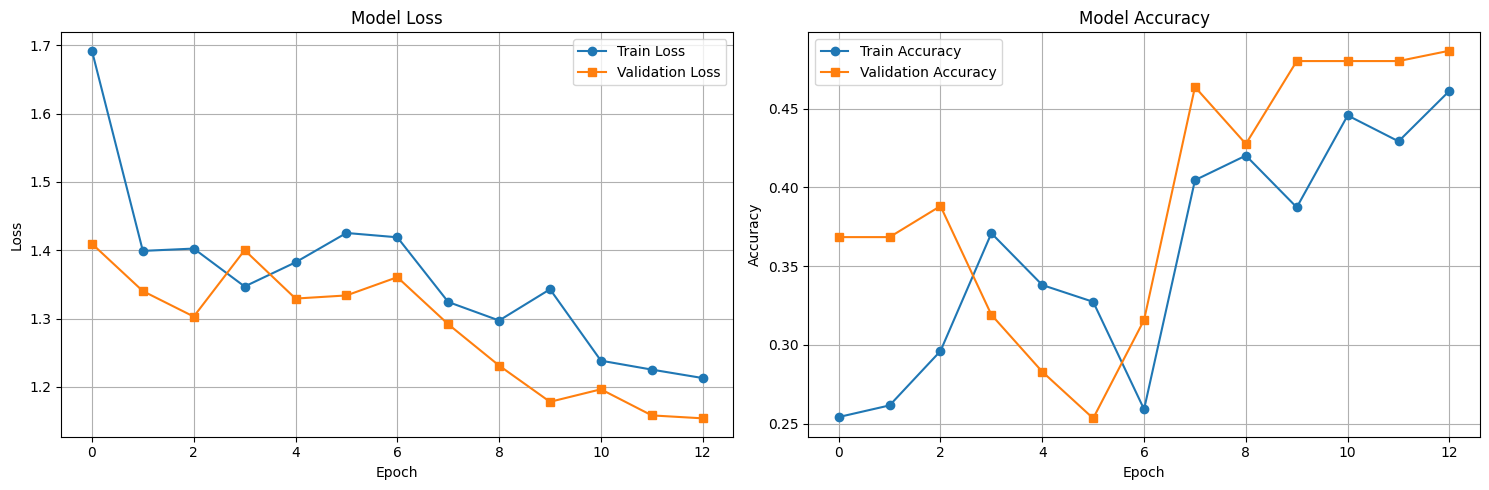

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  3.58it/s]


Test Accuracy: 24.87%
Test Loss: 1.5235

Classification Report:
              precision    recall  f1-score   support

         HGC       0.17      0.05      0.08        74
         LGC       0.31      0.53      0.39        53
         NST       0.34      0.41      0.37        37
         NTL       0.00      0.00      0.00        25

    accuracy                           0.25       189
   macro avg       0.21      0.25      0.21       189
weighted avg       0.22      0.25      0.22       189


Confusion Matrix:
[[ 4 31 27 12]
 [ 4 28  0 21]
 [12 10 15  0]
 [ 3 20  2  0]]

ROC-AUC Scores:
Macro-average AUC: 0.4652
Micro-average AUC: 0.5666
HGC AUC: 0.3100
LGC AUC: 0.5544
NST AUC: 0.6373
NTL AUC: 0.3590


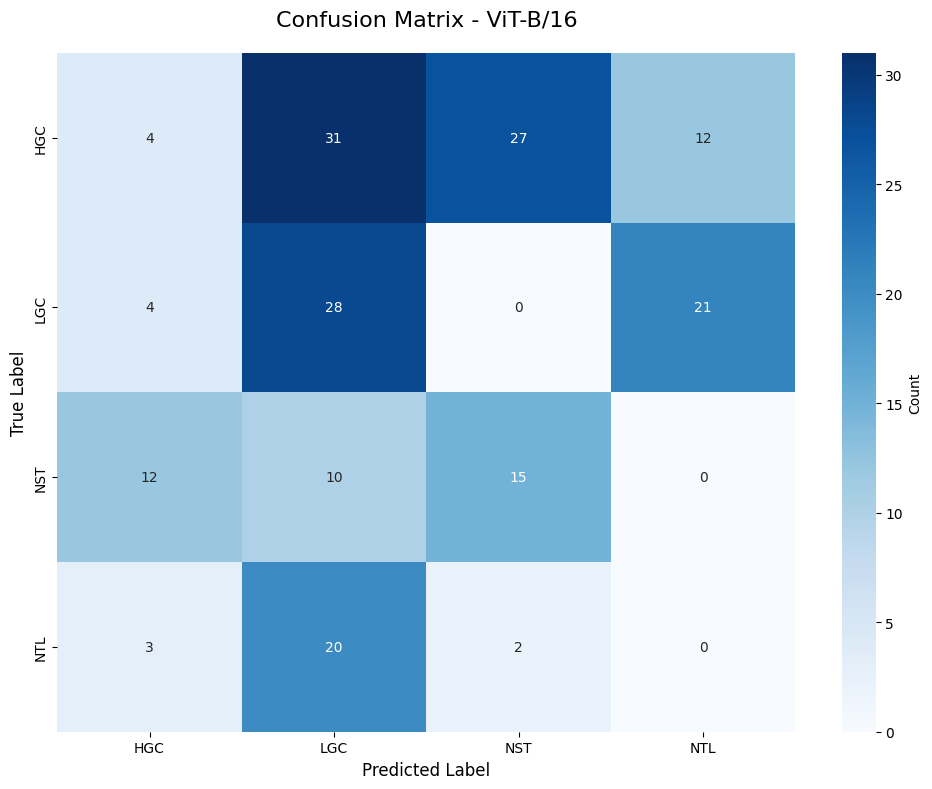

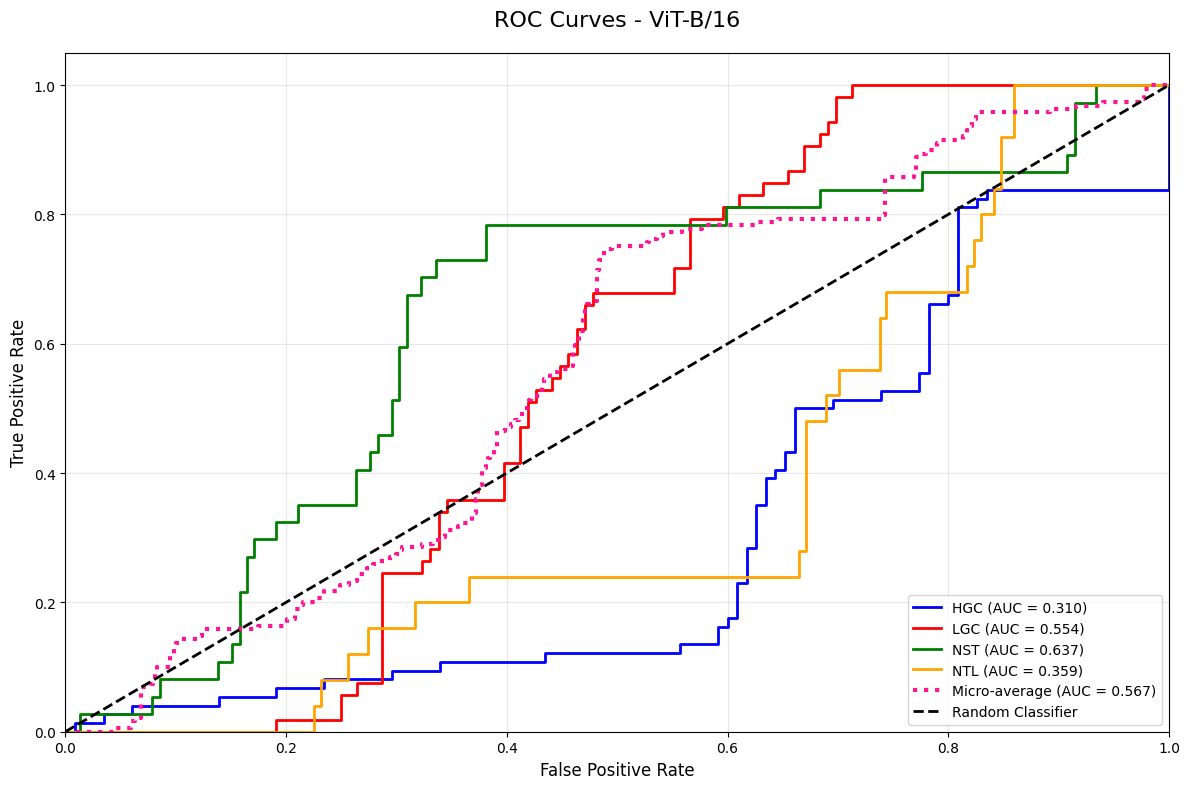


ViT-B/16 training and evaluation complete!


In [15]:
print("=" * 80)
print("Training Vision Transformer B/16 with Imaging Type")
print("=" * 80)

# Create model
vit_b16 = create_vit_model(num_classes=4, num_imaging_types=2, pretrained=True, model_type='b16')

# Create trainer
trainer_vit_b16 = ModelTrainer(vit_b16, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_vit_b16 = trainer_vit_b16.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="ViT-B16_with_ImagingType")

# Plot training history
trainer_vit_b16.plot_training_history(save_path='vit_b16_training_history.png')

# Evaluate model
results_vit_b16 = trainer_vit_b16.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_vit_b16['confusion_matrix'], class_names, 'ViT-B/16',
                      save_path='vit_b16_confusion_matrix.png')

# Plot ROC curves
roc_auc_vit_b16 = plot_roc_curves(results_vit_b16['labels'], results_vit_b16['probabilities'], class_names, 'ViT-B/16',
                                   save_path='vit_b16_roc_curves.png')

# Store results
results_vit_b16['model_name'] = 'ViT-B/16'
results_vit_b16['roc_auc'] = roc_auc_vit_b16
all_results.append(results_vit_b16)

print("\nViT-B/16 training and evaluation complete!")

## Train ViT-B/32

Training Vision Transformer B/32 with Imaging Type


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_32_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_32_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vit_b_32-d86f8d99.pth" to /root/.cache/torch/hub/checkpoints/vit_b_32-d86f8d99.pth


100%|██████████| 337M/337M [00:04<00:00, 82.9MB/s]


Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.71it/s, Loss=1.6101, Acc=0.2862]


Train Loss: 1.6101 Acc: 0.2862 Macro-F1: 0.2620


Val : 100%|██████████| 10/10 [00:00<00:00, 10.03it/s, Loss=1.3610, Acc=0.3125]


Val Loss: 1.3610 Acc: 0.3125 Macro-F1: 0.2433
✓ New best model saved with validation macro-F1: 0.2433

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.73it/s, Loss=1.3351, Acc=0.3873]


Train Loss: 1.3351 Acc: 0.3873 Macro-F1: 0.3451


Val : 100%|██████████| 10/10 [00:01<00:00,  9.82it/s, Loss=1.3439, Acc=0.2500]


Val Loss: 1.3439 Acc: 0.2500 Macro-F1: 0.2563
✓ New best model saved with validation macro-F1: 0.2563

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.74it/s, Loss=1.2499, Acc=0.4046]


Train Loss: 1.2499 Acc: 0.4046 Macro-F1: 0.3789


Val : 100%|██████████| 10/10 [00:01<00:00,  9.97it/s, Loss=1.1838, Acc=0.4507]


Val Loss: 1.1838 Acc: 0.4507 Macro-F1: 0.3560
✓ New best model saved with validation macro-F1: 0.3560

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.72it/s, Loss=1.2270, Acc=0.4490]


Train Loss: 1.2270 Acc: 0.4490 Macro-F1: 0.4088


Val : 100%|██████████| 10/10 [00:01<00:00,  9.94it/s, Loss=1.1649, Acc=0.4441]


Val Loss: 1.1649 Acc: 0.4441 Macro-F1: 0.3247

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.73it/s, Loss=1.3050, Acc=0.3840]


Train Loss: 1.3050 Acc: 0.3840 Macro-F1: 0.3684


Val : 100%|██████████| 10/10 [00:01<00:00,  9.95it/s, Loss=1.3610, Acc=0.2862]


Val Loss: 1.3610 Acc: 0.2862 Macro-F1: 0.1183

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.76it/s, Loss=1.3047, Acc=0.4054]


Train Loss: 1.3047 Acc: 0.4054 Macro-F1: 0.3769


Val : 100%|██████████| 10/10 [00:01<00:00,  9.99it/s, Loss=1.0961, Acc=0.5164]


Val Loss: 1.0961 Acc: 0.5164 Macro-F1: 0.4148
✓ New best model saved with validation macro-F1: 0.4148

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.69it/s, Loss=1.2331, Acc=0.4169]


Train Loss: 1.2331 Acc: 0.4169 Macro-F1: 0.3853


Val : 100%|██████████| 10/10 [00:01<00:00,  9.73it/s, Loss=1.0699, Acc=0.5197]


Val Loss: 1.0699 Acc: 0.5197 Macro-F1: 0.4070

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.74it/s, Loss=1.0771, Acc=0.5641]


Train Loss: 1.0771 Acc: 0.5641 Macro-F1: 0.4930


Val : 100%|██████████| 10/10 [00:01<00:00,  9.75it/s, Loss=1.0133, Acc=0.5362]


Val Loss: 1.0133 Acc: 0.5362 Macro-F1: 0.4608
✓ New best model saved with validation macro-F1: 0.4608

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.72it/s, Loss=1.0074, Acc=0.5551]


Train Loss: 1.0074 Acc: 0.5551 Macro-F1: 0.5104


Val : 100%|██████████| 10/10 [00:01<00:00,  9.92it/s, Loss=0.9532, Acc=0.6053]


Val Loss: 0.9532 Acc: 0.6053 Macro-F1: 0.5657
✓ New best model saved with validation macro-F1: 0.5657

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.73it/s, Loss=0.9546, Acc=0.5962]


Train Loss: 0.9546 Acc: 0.5962 Macro-F1: 0.5504


Val : 100%|██████████| 10/10 [00:01<00:00,  9.89it/s, Loss=0.9388, Acc=0.5888]


Val Loss: 0.9388 Acc: 0.5888 Macro-F1: 0.5432

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.75it/s, Loss=0.9239, Acc=0.6299]


Train Loss: 0.9239 Acc: 0.6299 Macro-F1: 0.5833


Val : 100%|██████████| 10/10 [00:01<00:00,  9.96it/s, Loss=0.9078, Acc=0.6250]


Val Loss: 0.9078 Acc: 0.6250 Macro-F1: 0.5791
✓ New best model saved with validation macro-F1: 0.5791

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.74it/s, Loss=0.8774, Acc=0.6554]


Train Loss: 0.8774 Acc: 0.6554 Macro-F1: 0.6083


Val : 100%|██████████| 10/10 [00:01<00:00,  9.94it/s, Loss=0.8817, Acc=0.6447]


Val Loss: 0.8817 Acc: 0.6447 Macro-F1: 0.6046
✓ New best model saved with validation macro-F1: 0.6046

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.74it/s, Loss=0.8514, Acc=0.6719]


Train Loss: 0.8514 Acc: 0.6719 Macro-F1: 0.6185


Val : 100%|██████████| 10/10 [00:01<00:00,  9.78it/s, Loss=0.8586, Acc=0.6283]


Val Loss: 0.8586 Acc: 0.6283 Macro-F1: 0.5881

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.72it/s, Loss=0.8459, Acc=0.6743]


Train Loss: 0.8459 Acc: 0.6743 Macro-F1: 0.6245


Val : 100%|██████████| 10/10 [00:01<00:00,  9.83it/s, Loss=0.8270, Acc=0.7039]


Val Loss: 0.8270 Acc: 0.7039 Macro-F1: 0.6665
✓ New best model saved with validation macro-F1: 0.6665

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.75it/s, Loss=0.7794, Acc=0.7122]


Train Loss: 0.7794 Acc: 0.7122 Macro-F1: 0.6607


Val : 100%|██████████| 10/10 [00:00<00:00, 10.25it/s, Loss=0.7799, Acc=0.7105]


Val Loss: 0.7799 Acc: 0.7105 Macro-F1: 0.6614

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.74it/s, Loss=0.7591, Acc=0.7253]


Train Loss: 0.7591 Acc: 0.7253 Macro-F1: 0.6717


Val : 100%|██████████| 10/10 [00:01<00:00,  9.91it/s, Loss=0.7807, Acc=0.7237]


Val Loss: 0.7807 Acc: 0.7237 Macro-F1: 0.6792
✓ New best model saved with validation macro-F1: 0.6792

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.71it/s, Loss=0.7605, Acc=0.7237]


Train Loss: 0.7605 Acc: 0.7237 Macro-F1: 0.6729


Val : 100%|██████████| 10/10 [00:01<00:00,  9.54it/s, Loss=0.7712, Acc=0.6941]


Val Loss: 0.7712 Acc: 0.6941 Macro-F1: 0.6535

Epoch 18/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.76it/s, Loss=0.7461, Acc=0.7229]


Train Loss: 0.7461 Acc: 0.7229 Macro-F1: 0.6733


Val : 100%|██████████| 10/10 [00:00<00:00, 10.10it/s, Loss=0.7732, Acc=0.7237]


Val Loss: 0.7732 Acc: 0.7237 Macro-F1: 0.6805
✓ New best model saved with validation macro-F1: 0.6805

Epoch 19/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.74it/s, Loss=0.7487, Acc=0.7220]


Train Loss: 0.7487 Acc: 0.7220 Macro-F1: 0.6750


Val : 100%|██████████| 10/10 [00:01<00:00,  9.89it/s, Loss=0.7704, Acc=0.7007]


Val Loss: 0.7704 Acc: 0.7007 Macro-F1: 0.6572

Epoch 20/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.74it/s, Loss=0.7349, Acc=0.7245]


Train Loss: 0.7349 Acc: 0.7245 Macro-F1: 0.6786


Val : 100%|██████████| 10/10 [00:00<00:00, 10.06it/s, Loss=0.7600, Acc=0.7270]


Val Loss: 0.7600 Acc: 0.7270 Macro-F1: 0.6878
✓ New best model saved with validation macro-F1: 0.6878

Epoch 21/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.74it/s, Loss=0.7348, Acc=0.7352]


Train Loss: 0.7348 Acc: 0.7352 Macro-F1: 0.6893


Val : 100%|██████████| 10/10 [00:01<00:00,  9.60it/s, Loss=0.7608, Acc=0.7336]


Val Loss: 0.7608 Acc: 0.7336 Macro-F1: 0.6994
✓ New best model saved with validation macro-F1: 0.6994

Epoch 22/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.72it/s, Loss=0.7329, Acc=0.7385]


Train Loss: 0.7329 Acc: 0.7385 Macro-F1: 0.6906


Val : 100%|██████████| 10/10 [00:01<00:00,  9.96it/s, Loss=0.7568, Acc=0.7368]


Val Loss: 0.7568 Acc: 0.7368 Macro-F1: 0.7039
✓ New best model saved with validation macro-F1: 0.7039

Epoch 23/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.70it/s, Loss=0.7298, Acc=0.7368]


Train Loss: 0.7298 Acc: 0.7368 Macro-F1: 0.6897


Val : 100%|██████████| 10/10 [00:01<00:00,  9.87it/s, Loss=0.7553, Acc=0.7270]


Val Loss: 0.7553 Acc: 0.7270 Macro-F1: 0.6879

Epoch 24/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.76it/s, Loss=0.7229, Acc=0.7368]


Train Loss: 0.7229 Acc: 0.7368 Macro-F1: 0.6880


Val : 100%|██████████| 10/10 [00:01<00:00,  9.74it/s, Loss=0.7554, Acc=0.7237]


Val Loss: 0.7554 Acc: 0.7237 Macro-F1: 0.6842

Epoch 25/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.74it/s, Loss=0.7211, Acc=0.7385]


Train Loss: 0.7211 Acc: 0.7385 Macro-F1: 0.6907


Val : 100%|██████████| 10/10 [00:01<00:00,  9.88it/s, Loss=0.7556, Acc=0.7270]


Val Loss: 0.7556 Acc: 0.7270 Macro-F1: 0.6867

Training complete in 3m 22s
Best validation macro-F1: 0.7039


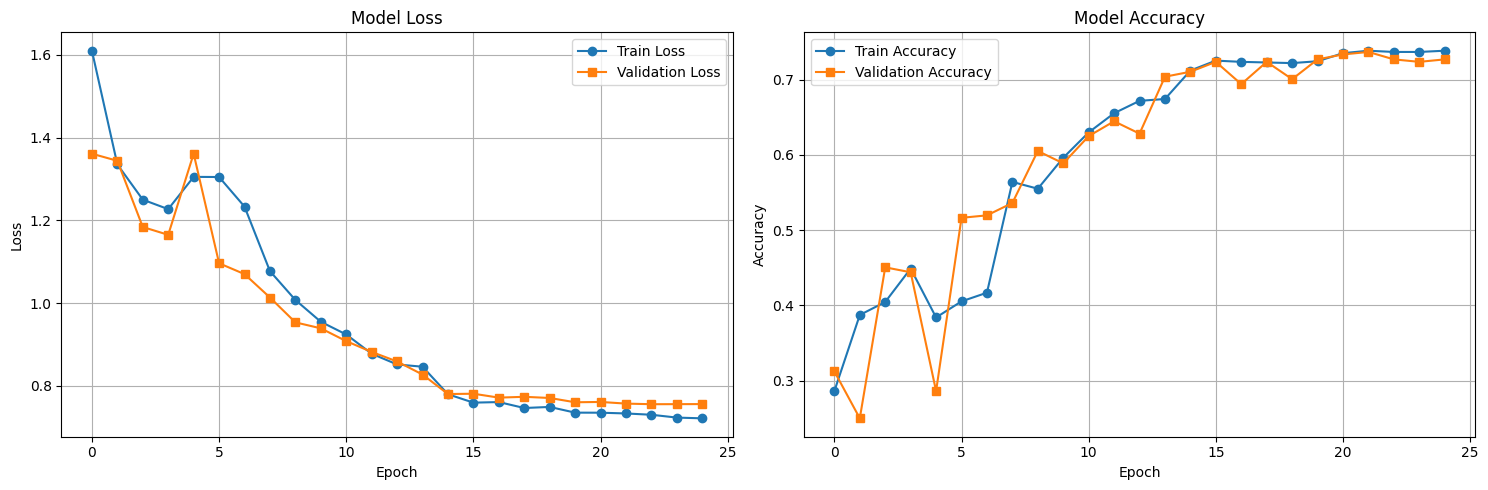

Evaluating on test set...


100%|██████████| 6/6 [00:00<00:00,  8.10it/s]


Test Accuracy: 37.57%
Test Loss: 1.7461

Classification Report:
              precision    recall  f1-score   support

         HGC       0.58      0.51      0.54        74
         LGC       0.60      0.06      0.10        53
         NST       0.25      0.32      0.28        37
         NTL       0.26      0.72      0.38        25

    accuracy                           0.38       189
   macro avg       0.42      0.40      0.33       189
weighted avg       0.48      0.38      0.35       189


Confusion Matrix:
[[38  2 26  8]
 [19  3  8 23]
 [ 4  0 12 21]
 [ 5  0  2 18]]

ROC-AUC Scores:
Macro-average AUC: 0.6230
Micro-average AUC: 0.5919
HGC AUC: 0.6961
LGC AUC: 0.4806
NST AUC: 0.5912
NTL AUC: 0.7241


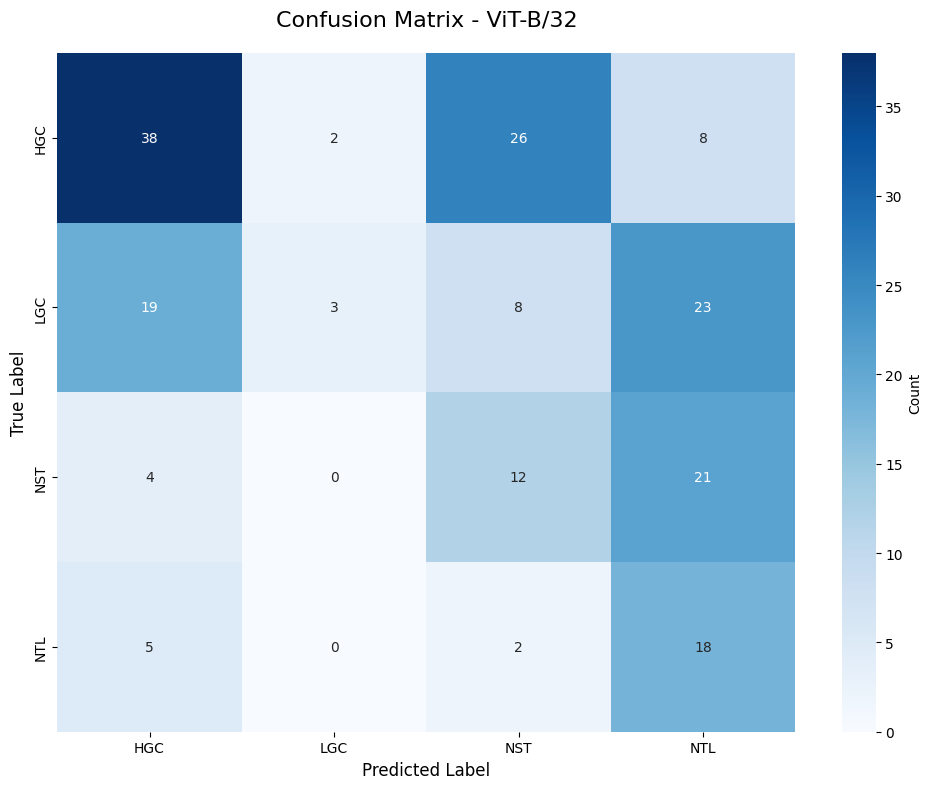

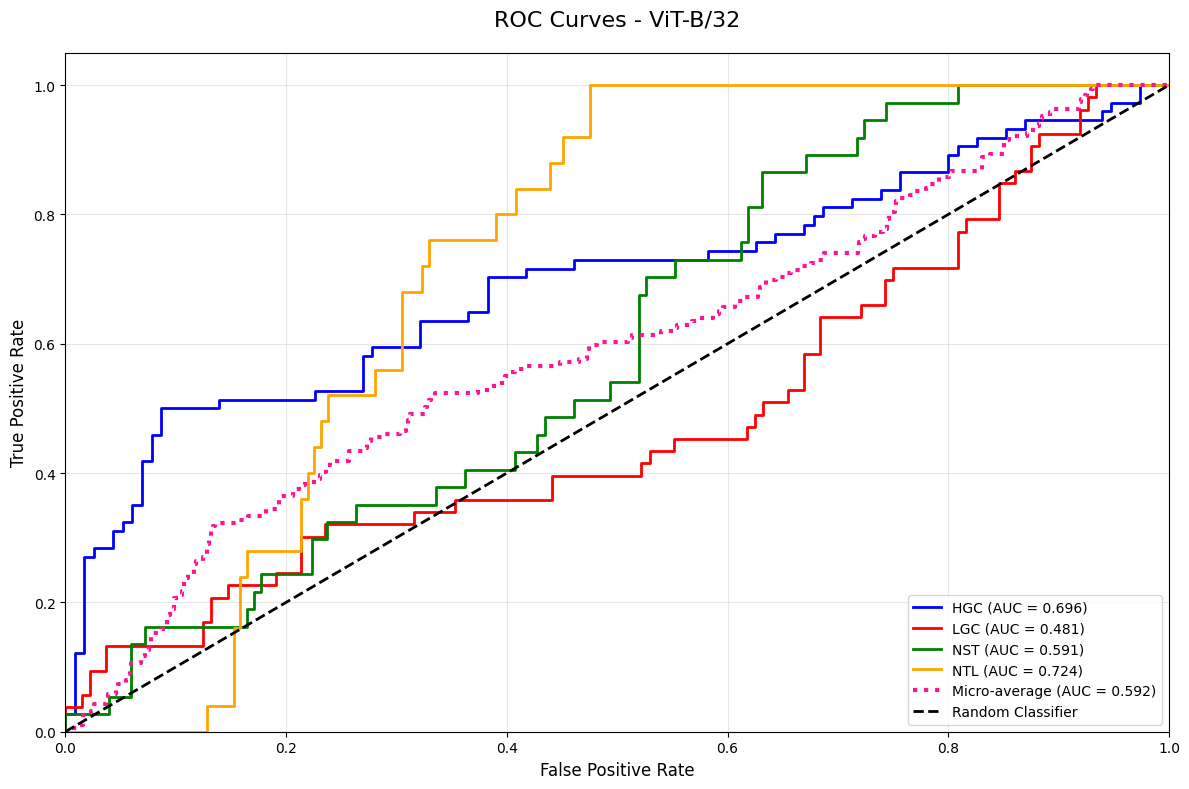


ViT-B/32 training and evaluation complete!


In [16]:
print("=" * 80)
print("Training Vision Transformer B/32 with Imaging Type")
print("=" * 80)

# Create model
vit_b32 = create_vit_model(num_classes=4, num_imaging_types=2, pretrained=True, model_type='b32')

# Create trainer
trainer_vit_b32 = ModelTrainer(vit_b32, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_vit_b32 = trainer_vit_b32.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="ViT-B32_with_ImagingType")

# Plot training history
trainer_vit_b32.plot_training_history(save_path='vit_b32_training_history.png')

# Evaluate model
results_vit_b32 = trainer_vit_b32.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_vit_b32['confusion_matrix'], class_names, 'ViT-B/32',
                      save_path='vit_b32_confusion_matrix.png')

# Plot ROC curves
roc_auc_vit_b32 = plot_roc_curves(results_vit_b32['labels'], results_vit_b32['probabilities'], class_names, 'ViT-B/32',
                                   save_path='vit_b32_roc_curves.png')

# Store results
results_vit_b32['model_name'] = 'ViT-B/32'
results_vit_b32['roc_auc'] = roc_auc_vit_b32
all_results.append(results_vit_b32)

print("\nViT-B/32 training and evaluation complete!")

# Save All Metrics to CSV

In [17]:
# Prepare data for CSV
metrics_data = []

for result in all_results:
    model_name = result['model_name']
    report = result['classification_report']
    
    # Overall metrics
    row = {
        'Model': model_name,
        'Overall_Accuracy': result['accuracy'],
        'Overall_Loss': result['loss'],
        'Macro_Avg_Precision': report['macro avg']['precision'],
        'Macro_Avg_Recall': report['macro avg']['recall'],
        'Macro_Avg_F1': report['macro avg']['f1-score'],
        'Weighted_Avg_Precision': report['weighted avg']['precision'],
        'Weighted_Avg_Recall': report['weighted avg']['recall'],
        'Weighted_Avg_F1': report['weighted avg']['f1-score'],
    }
    
    # Per-class metrics
    for class_name in class_names:
        row[f'{class_name}_Precision'] = report[class_name]['precision']
        row[f'{class_name}_Recall'] = report[class_name]['recall']
        row[f'{class_name}_F1'] = report[class_name]['f1-score']
        row[f'{class_name}_Support'] = report[class_name]['support']
    
    # ROC-AUC scores
    row['Macro_AUC'] = result['macro_auc']
    row['Micro_AUC'] = result['micro_auc']
    for class_name in class_names:
        row[f'{class_name}_AUC'] = result['per_class_auc'][class_name]
    
    # Also store ROC-AUC from plot_roc_curves if available
    if 'roc_auc' in result:
        for i, class_name in enumerate(class_names):
            row[f'{class_name}_Plot_AUC'] = result['roc_auc'][i]
        row['Micro_Avg_Plot_AUC'] = result['roc_auc']['micro']
    
    metrics_data.append(row)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
csv_path = 'ViT_metrics.csv'
metrics_df.to_csv(csv_path, index=False)

print(f"\nMetrics saved to: {csv_path}")
print("\nMetrics Summary:")
print(metrics_df.to_string())


Metrics saved to: ViT_metrics.csv

Metrics Summary:
      Model  Overall_Accuracy  Overall_Loss  Macro_Avg_Precision  Macro_Avg_Recall  Macro_Avg_F1  Weighted_Avg_Precision  Weighted_Avg_Recall  Weighted_Avg_F1  HGC_Precision  HGC_Recall    HGC_F1  HGC_Support  LGC_Precision  LGC_Recall    LGC_F1  LGC_Support  NST_Precision  NST_Recall    NST_F1  NST_Support  NTL_Precision  NTL_Recall    NTL_F1  NTL_Support  Macro_AUC  Micro_AUC   HGC_AUC   LGC_AUC   NST_AUC   NTL_AUC  HGC_Plot_AUC  LGC_Plot_AUC  NST_Plot_AUC  NTL_Plot_AUC  Micro_Avg_Plot_AUC
0  ViT-B/16         24.867725      1.523474             0.207357           0.24694      0.211803                0.223055             0.248677         0.215387       0.173913    0.054054  0.082474         74.0       0.314607    0.528302  0.394366         53.0       0.340909    0.405405  0.370370         37.0       0.000000        0.00  0.000000         25.0   0.465166   0.566567  0.309988  0.554384  0.637269  0.359024      0.309988      0.554384  